In [1]:
import pandas as pd
import numpy as np
import time
import json
import pickle
import os
from datetime import datetime
import matplotlib.pyplot as plt
# import seaborn as sns  # just use matplotlib
from sentence_transformers import CrossEncoder #SentenceTransformer (call from evaluation.metrics)
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

# Use the exact same evaluation functions
import sys
sys.path.append('../src')
from text_processing.combining import create_combined_text_v1
from utils.vector_db import VectorDatabaseManager
from search.semantic import SemanticSearcher
from search.hybrid import HybridSearcher
from evaluation.metrics import evaluate_search_system #calculate_hits_at_k, calculate_mrr (included in evaluation.metrics) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Load exact sampled dataset
df = pd.read_parquet("../data/processed/df.parquet")
print(f"Dataset shape: {df.shape}")
print(f"Unique queries: {df['query'].nunique()}")
print(f"Columns: {df.columns.tolist()}")

# Check if combined_text exists, if not create it using demo function
if 'combined_text_v1' not in df.columns:
    print("Creating combined_text using demo v1 function (2000 char limit)...")
    df['combined_text_v1'] = df.apply(lambda row: create_combined_text_v1(row, max_chars=2000), axis=1)
    print("Created combined_text_v1 column")

df.head()

Dataset shape: (519, 10)
Unique queries: 53
Columns: ['example_id', 'query', 'query_id', 'product_id', 'split', 'product_title', 'product_description', 'product_bullet_point', 'product_brand', 'product_color']
Creating combined_text using demo v1 function (2000 char limit)...
Created combined_text_v1 column


,example_id,query,query_id,product_id,split,product_title,product_description,product_bullet_point,product_brand,product_color,combined_text_v1
0,20232,1 cup coffee maker without water reservoir,711,B07GV2S1GS,train,"Keurig K-Mini Coffee Maker, Single Serve K-Cup...",None,"FITS ANYWHERE: Less than 5 inches wide, perfec...",Keurig,Black,"keurig k-mini coffee maker, single serve k-cup..."
1,20235,1 cup coffee maker without water reservoir,711,B07Q5CG2MH,train,Hamilton Beach FlexBrew Single-Serve Maker wit...,None,Single-Serve Coffee Maker With or Without K-Cu...,Hamilton Beach,Black and Silver,hamilton beach flexbrew single-serve maker wit...
2,20239,1 cup coffee maker without water reservoir,711,B07ZHNDYDY,train,"CHEFMAN Single Serve One Cup Coffee Maker, up ...",None,FAST BREW TIME: With this single serve coffee ...,Chefman,Instacoffe Single Serve Coffee Maker,"chefman single serve one cup coffee maker, up ..."
3,20242,1 cup coffee maker without water reservoir,711,B088WMVG9D,train,EZBASICS Single Serve Coffee Maker Brewer Comp...,EZBASICS Single Serve Coffee Brewer features a...,Compatible with K-Cup or Ground Coffee - This ...,EZBASICS,black,ezbasics single serve coffee maker brewer comp...
4,20244,1 cup coffee maker without water reservoir,711,B08C4VZ252,train,"CHULUX Single Cup Coffee Maker Machine,12 Ounc...",coffee maker,【Single Cup Coffee Design】CHULUX coffee machin...,CHULUX,Cyan,"chulux single cup coffee maker machine,12 ounc..."


In [4]:
# Model configurations for 2 vector databases + cross-encoder demo
models_config = {
    'miniLM_base': {
        'name': 'all-MiniLM-L6-v2',
        'type': 'bi-encoder',
        'expected_dims': 384,
        'db_name': 'miniLM_base'
    },
    'mpnet_base': {
        'name': 'all-mpnet-base-v2',
        'type': 'bi-encoder', 
        'expected_dims': 768,
        'db_name': 'mpnet_base'
    },
    'cross-encoder': {
        'name': 'cross-encoder/ms-marco-MiniLM-L6-v2',
        'type': 'cross-encoder',
        'expected_dims': None,
        'db_name': None
    }
}

print("Search approaches to test:")
for key, config in models_config.items():
    if config.get('type') != 'cross-encoder':
        print(f"  {key}: {config['name']} (semantic + hybrid search)")
    else:
        print(f"  {key}: {config['name']} (for timing demo)")
print(f"\nTotal vector databases to create: 2")

Search approaches to test:
  miniLM_base: all-MiniLM-L6-v2 (semantic + hybrid search)
  mpnet_base: all-mpnet-base-v2 (semantic + hybrid search)
  cross-encoder: cross-encoder/ms-marco-MiniLM-L6-v2 (for timing demo)

Total vector databases to create: 2


In [ ]:
# Load keywords for hybrid search
with open('../src/text_processing/artifacts/light_keywords.json', 'r') as f:
    light_keywords = json.load(f)
print(f"Loaded {len(light_keywords)} keywords for hybrid search\n")

# Setup vector database manager 
db_manager = VectorDatabaseManager('../src/vector_databases')

# Create fresh vector databases and searchers for all 4 approaches
searchers = {}
embedding_times = {}

print("Creating fresh vector databases and searchers...\n")

for model_key, config in models_config.items():
    if config['type'] in ['bi-encoder']:
        print(f"Processing {model_key}: {config['name']}")
    
        start_time = time.time()
 
        # Create new vector database for this approach
        db_name = config['db_name']
        print(f"  Creating new database: {db_name}")
        
        model, db, table = db_manager.create_database(
            df, 'combined_text_v1', db_name, config['name'], 'products'
        )
        
        # Create semantic search
        semantic_searcher = SemanticSearcher(model_name=config['name'])
        semantic_searcher.model = model
        semantic_searcher.db = db
        semantic_searcher.table = table
        semantic_searcher.fitted = True
        searchers[f"{model_key}_semantic"] = semantic_searcher
        print(f"  SemanticSearcher ready")
            
       
        # Create hybrid searcher with keywords
        hybrid_searcher = HybridSearcher(
            model_name=config['name'],
            keywords_dict=light_keywords,
            alpha=0.7,  # 70% semantic
            beta=0.3    # 30% keyword
        )
        hybrid_searcher.model = model
        hybrid_searcher.db = db
        hybrid_searcher.table = table
        hybrid_searcher.fitted = True
        searchers[f"{model_key}_hybrid"] = hybrid_searcher
        print(f"  HybridSearcher ready (alpha=0.7, beta=0.3)")
        
    elif config['type'] == 'cross-encoder':
        model = CrossEncoder(config['name'])
        searchers[model_key] = model  
        print(f"  CrossEncoder loaded (for timing demo)")
    
    load_time = time.time() - start_time
    embedding_times[model_key] = load_time
    print(f"  Time: {load_time:.2f}s\n")

print("="*60)
print("CREATED 2 NEW VECTOR DATABASES:")
print("="*60)
for model_key, config in models_config.items():
    if config['db_name']:
        print(f"  {model_key:20} → {config['db_name']}")
print("="*60)

Loaded 150 keywords for hybrid search

Creating fresh vector databases and searchers...

Processing miniLM_base: all-MiniLM-L6-v2
  Creating new database: miniLM_base
Creating vector database: miniLM_base
Creating embeddings for 519 texts...


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Created database 'miniLM_base' with 519 vectors
  SemanticSearcher ready
  HybridSearcher ready (alpha=0.7, beta=0.3)
  Time: 12.14s

Processing mpnet_base: all-mpnet-base-v2
  Creating new database: mpnet_base
Creating vector database: mpnet_base
Creating embeddings for 519 texts...


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Created database 'mpnet_base' with 519 vectors
  SemanticSearcher ready
  HybridSearcher ready (alpha=0.7, beta=0.3)
  Time: 116.27s

  CrossEncoder loaded (for timing demo)
  Time: 116.91s

CREATED 2 NEW VECTOR DATABASES:
  miniLM_base          → miniLM_base
  mpnet_base           → mpnet_base


In [7]:
# Search functions for all approaches
def search_with_pipeline(searcher, query, top_k=10):
    """Search using SemanticSearcher or HybridSearcher"""
    results = searcher.search(query, top_k=top_k)
    # Convert LanceDB results to format expected by evaluation
    if hasattr(results, 'to_pandas'):
        results = results.to_pandas()
    # Ensure we have score column properly named
    if '_distance' in results.columns:
        results['score'] = 1 - results['_distance']
        results = results.drop('_distance', axis=1)
    return results

def cross_encoder_search(query, df, model, top_k=10):
    """Search using cross-encoder model (score all pairs)"""
    query_product_pairs = [(query, text) for text in df['combined_text_v1']]
    scores = model.predict(query_product_pairs)
    
    top_indices = scores.argsort()[-top_k:][::-1]
    results = df.iloc[top_indices].copy()
    results['score'] = scores[top_indices]
    
    return results

In [9]:
# Test all 4 search approaches plus cross-encoder
test_query = "coffee maker"
print(f"Testing all search approaches with query: '{test_query}'\n")

for model_key, config in models_config.items():
    if config['type'] == 'bi-encoder':
        model_name = config['name'].split('-')[1]  # Extract miniLM or mpnet
        
        # Test semantic search
        semantic_key = f"{model_key}_semantic"
        results = search_with_pipeline(searchers[semantic_key], test_query, top_k=5)
        print(f"{model_name} Semantic top 5:")
        for idx, row in results.iterrows():
            print(f"  {row['score']:.3f}: {row['product_title'][:60]}...")
        print()
        
        # Test hybrid search
        hybrid_key = f"{model_key}_hybrid"
        results = search_with_pipeline(searchers[hybrid_key], test_query, top_k=5)
        print(f"{model_name} Hybrid top 5:")
        for idx, row in results.iterrows():
            print(f"  {row['score']:.3f}: {row['product_title'][:60]}...")
        print()
        
    elif config['type'] == 'cross-encoder':
        results = cross_encoder_search(test_query, df, searchers[model_key], top_k=5)
        print(f"Cross-encoder top 5:")
        for idx, row in results.iterrows():
            print(f"  {row['score']:.3f}: {row['product_title'][:60]}...")
        print()

Testing all search approaches with query: 'coffee maker'

MiniLM Semantic top 5:
  0.611: Presto 02835 MyJo Single Cup Coffee Maker, Black...
  0.601: Cuisinart DCC-3200P1 Perfectemp Coffee Maker, 14 Cup Progamm...
  0.578: CHEFMAN Single Serve One Cup Coffee Maker, up to 14 Oz, Inst...
  0.569: Elite Gourmet EHC111A Maxi-Matic Personal 14oz Single-Serve ...
  0.549: Hamilton Beach (47950) Coffee Maker with 12 Cup Capacity & I...

MiniLM Hybrid top 5:
  0.728: Presto 02835 MyJo Single Cup Coffee Maker, Black...
  0.721: Cuisinart DCC-3200P1 Perfectemp Coffee Maker, 14 Cup Progamm...
  0.705: CHEFMAN Single Serve One Cup Coffee Maker, up to 14 Oz, Inst...
  0.699: Elite Gourmet EHC111A Maxi-Matic Personal 14oz Single-Serve ...
  0.684: Hamilton Beach (47950) Coffee Maker with 12 Cup Capacity & I...

mpnet Semantic top 5:
  0.709: Presto 02835 MyJo Single Cup Coffee Maker, Black...
  0.691: Single Serve K Cup Coffee Maker for K-Cup Pods and Ground Co...
  0.680: CHEFMAN Single Serve One 

In [10]:
# Test with different query
test_query = "women's dress"
print(f"Testing all search approaches with query: '{test_query}'\n")

for model_key, config in models_config.items():
    if config['type'] == 'bi-encoder':
        model_name = config['name'].split('-')[1]  # Extract miniLM or mpnet
        
        # Test semantic search
        semantic_key = f"{model_key}_semantic"
        results = search_with_pipeline(searchers[semantic_key], test_query, top_k=5)
        print(f"{model_name} Semantic top 5:")
        for idx, row in results.iterrows():
            print(f"  {row['score']:.3f}: {row['product_title'][:60]}...")
        print()
        
        # Test hybrid search
        hybrid_key = f"{model_key}_hybrid"
        results = search_with_pipeline(searchers[hybrid_key], test_query, top_k=5)
        print(f"{model_name} Hybrid top 5:")
        for idx, row in results.iterrows():
            print(f"  {row['score']:.3f}: {row['product_title'][:60]}...")
        print()
        
    elif config['type'] == 'cross-encoder':
        results = cross_encoder_search(test_query, df, searchers[model_key], top_k=5)
        print(f"Cross-encoder top 5:")
        for idx, row in results.iterrows():
            print(f"  {row['score']:.3f}: {row['product_title'][:60]}...")
        print()

Testing all search approaches with query: 'women's dress'

MiniLM Semantic top 5:
  0.529: Womens Liturgical Praise Lyrical Dance Dress Loose Fit Full ...
  0.528: Fanient Womens Casual Dress Rainbow Unicorn Print Sleeveless...
  0.522: Women Metallic Color Block Liturgical Praise Dance Dress Bel...
  0.513: Women's Elegant Off Shoulder Summer Long Ruffle Beach Maxi D...
  0.505: Vijiv Vintage 1920s Long Wedding Prom Dresses 2/3 Sleeve Seq...

MiniLM Hybrid top 5:
  0.670: Womens Liturgical Praise Lyrical Dance Dress Loose Fit Full ...
  0.659: Women's Elegant Off Shoulder Summer Long Ruffle Beach Maxi D...
  0.646: Women's Rainbow Short Sleeve A-Line and Flare Midi Long Dres...
  0.574: Leg Avenue Women's, Faux Lace Black, One Size...
  0.570: Hanes Silk Reflections Hanes Women's Opaque Control Top XTEM...

mpnet Semantic top 5:
  0.622: PrettyGuide Women 's 1920s Art Deco Sequin Gatsby Formal Eve...
  0.618: Women Metallic Color Block Liturgical Praise Dance Dress Bel...
  0.611: Wom

In [11]:
# Benchmark query speeds for all approaches
test_queries = df['query'].unique()[:10]  # Use first 10 unique queries
query_times = {}

print(f"Benchmarking query speed on {len(test_queries)} queries...\n")

# Test semantic and hybrid for each database
for model_key, config in models_config.items():
    if config['type'] == 'bi-encoder':
        model_name = config['name'].split('-')[1]
        
        # Test semantic search speed
        semantic_key = f"{model_key}_semantic"
        print(f"Testing {model_name} Semantic...")
        times = []
        
        for query in test_queries:
            start_time = time.time()
            _ = search_with_pipeline(searchers[semantic_key], query, top_k=10)
            query_time = time.time() - start_time
            times.append(query_time)
        
        avg_time = np.mean(times)
        query_times[semantic_key] = avg_time
        print('='*40)
        print(f"  Average query time: {avg_time:.4f}s")
        print(f"  Queries per second: {1/avg_time:.1f}")
        print('='*40)
        
        # Test hybrid search speed
        hybrid_key = f"{model_key}_hybrid"
        print(f"Testing {model_name} Hybrid...")
        times = []
        
        for query in test_queries:
            start_time = time.time()
            _ = search_with_pipeline(searchers[hybrid_key], query, top_k=10)
            query_time = time.time() - start_time
            times.append(query_time)
        
        avg_time = np.mean(times)
        query_times[hybrid_key] = avg_time
        print('='*40)
        print(f"  Average query time: {avg_time:.4f}s")
        print(f"  Queries per second: {1/avg_time:.1f}")
        print('='*40)
        
    elif config['type'] == 'cross-encoder':
        print(f"Testing cross-encoder...")
        times = []
        
        for query in test_queries:
            start_time = time.time()
            _ = cross_encoder_search(query, df, searchers[model_key], top_k=10)
            query_time = time.time() - start_time
            times.append(query_time)
        
        avg_time = np.mean(times)
        query_times[model_key] = avg_time
        print('='*40)
        print(f"  Average query time: {avg_time:.4f}s")
        print(f"  Queries per second: {1/avg_time:.1f}")
        print('='*40)

Benchmarking query speed on 10 queries...

Testing MiniLM Semantic...
  Average query time: 0.0193s
  Queries per second: 51.8
Testing MiniLM Hybrid...
  Average query time: 0.0175s
  Queries per second: 57.1
Testing mpnet Semantic...
  Average query time: 0.0378s
  Queries per second: 26.5
Testing mpnet Hybrid...
  Average query time: 0.0393s
  Queries per second: 25.4
Testing cross-encoder...
  Average query time: 32.7926s
  Queries per second: 0.0


* Cross-encoder had long processing time for just 10 queries
* Focus on head-to-head comparison between miniLM (384 dims) vs mpnet (768 dims)

In [12]:
# Comprehensive evaluation of both semantic and hybrid search
print("Running comprehensive evaluation for semantic and hybrid search...")
print("="*80)

# Use existing search_with_pipeline function for evaluation
def evaluation_wrapper(searcher):
    """Wrapper that uses our existing search_with_pipeline function"""
    def search_wrapper(query, df, top_k=10):
        return search_with_pipeline(searcher, query, top_k)
    return search_wrapper

evaluation_results = {}

# Evaluate both semantic and hybrid search on each database
databases_to_evaluate = ['miniLM_base', 'mpnet_base']
search_types = ['semantic', 'hybrid']

for db_key in databases_to_evaluate:
    config = models_config[db_key]
    
    for search_type in search_types:
        approach_key = f"{db_key}_{search_type}"
        searcher = searchers[approach_key]
        
        model_name = config['name'].split('-')[1].upper()
        
        print(f"\nEvaluating {model_name} {search_type}:")
        print(f"  Model: {config['name']}")
        print(f"  Database: {config['db_name']}")
        print(f"  Dimensions: {config['expected_dims']}")
    
        # Use existing search function
        search_wrapper = evaluation_wrapper(searcher)
        results = evaluate_search_system(df, search_wrapper, k_values=[1, 5, 10])
        evaluation_results[approach_key] = results
        
        print(f"  HITS@1:  {results['hits_at_1']:.3f} ({results['hits_at_1']:.1%})")
        print(f"  HITS@5:  {results['hits_at_5']:.3f} ({results['hits_at_5']:.1%})")
        print(f"  HITS@10: {results['hits_at_10']:.3f} ({results['hits_at_10']:.1%})")
        print(f"  MRR:     {results['mrr']:.3f}")

print("\n" + "="*80)
print("EVALUATION SUMMARY TABLE")
print("="*80)
print(f"{'Approach':<20} {'HITS@1':<8} {'HITS@5':<8} {'HITS@10':<9} {'MRR':<8} {'Speed (s)':<10}")
print("-" * 80)

for db_key in databases_to_evaluate:
    for search_type in search_types:
        approach_key = f"{db_key}_{search_type}"
        if approach_key in evaluation_results:
            config = models_config[db_key]
            results = evaluation_results[approach_key]
            model_name = config['name'].split('-')[1].upper()
            display_name = f"{model_name} {search_type.capitalize()}"
            
            print(f"{display_name:<20} {results['hits_at_1']:<8.3f} {results['hits_at_5']:<8.3f} {results['hits_at_10']:<9.3f} {results['mrr']:<8.3f} {query_times[approach_key]:<10.4f}")

print("="*80)

Running comprehensive evaluation for semantic and hybrid search...

Evaluating MINILM semantic:
  Model: all-MiniLM-L6-v2
  Database: miniLM_base
  Dimensions: 384
Evaluating on 53 unique queries...
  HITS@1:  0.962 (96.2%)
  HITS@5:  0.981 (98.1%)
  HITS@10: 0.981 (98.1%)
  MRR:     0.972

Evaluating MINILM hybrid:
  Model: all-MiniLM-L6-v2
  Database: miniLM_base
  Dimensions: 384
Evaluating on 53 unique queries...
  HITS@1:  0.962 (96.2%)
  HITS@5:  0.981 (98.1%)
  HITS@10: 0.981 (98.1%)
  MRR:     0.972

Evaluating MPNET semantic:
  Model: all-mpnet-base-v2
  Database: mpnet_base
  Dimensions: 768
Evaluating on 53 unique queries...
  HITS@1:  0.943 (94.3%)
  HITS@5:  0.981 (98.1%)
  HITS@10: 1.000 (100.0%)
  MRR:     0.962

Evaluating MPNET hybrid:
  Model: all-mpnet-base-v2
  Database: mpnet_base
  Dimensions: 768
Evaluating on 53 unique queries...
  HITS@1:  1.000 (100.0%)
  HITS@5:  1.000 (100.0%)
  HITS@10: 1.000 (100.0%)
  MRR:     1.000

EVALUATION SUMMARY TABLE
Approach     

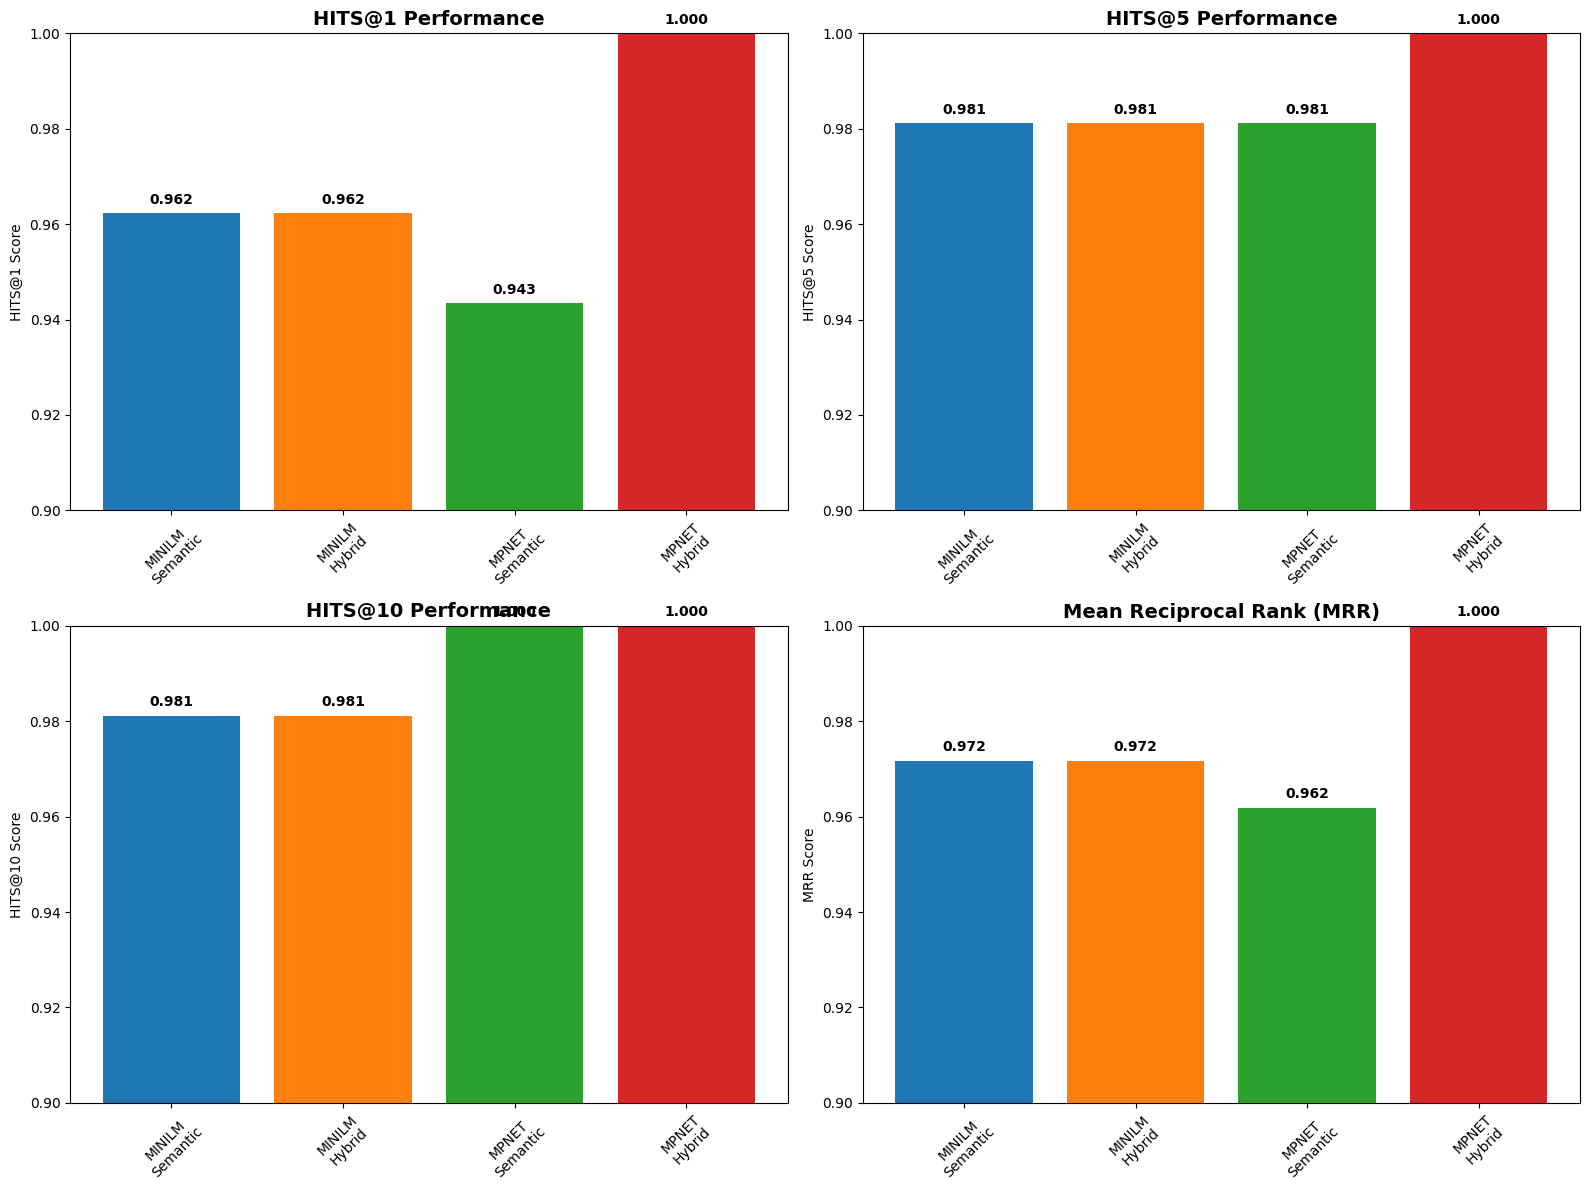

In [13]:
# Analysis and visualization of evaluation results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Prepare data for visualization
approaches = ['miniLM_base_semantic', 'miniLM_base_hybrid', 'mpnet_base_semantic', 'mpnet_base_hybrid']
approach_labels = []
hits1_scores = []
hits5_scores = []
hits10_scores = []
mrr_scores = []
speed_scores = []

colors = {
    'miniLM_base_semantic': '#1f77b4',   # Blue
    'miniLM_base_hybrid': '#ff7f0e',     # Orange  
    'mpnet_base_semantic': '#2ca02c',    # Green
    'mpnet_base_hybrid': '#d62728'       # Red
}

for approach in approaches:
    # Extract base model key and search type
    if '_semantic' in approach:
        base_key = approach.replace('_semantic', '')
        search_type = 'Semantic'
    else:
        base_key = approach.replace('_hybrid', '')
        search_type = 'Hybrid'
    
    config = models_config[base_key]
    results = evaluation_results[approach]
    
    model_name = config['name'].split('-')[1].upper()
    label = f"{model_name}\n{search_type}"
    
    approach_labels.append(label)
    hits1_scores.append(results['hits_at_1'])
    hits5_scores.append(results['hits_at_5'])
    hits10_scores.append(results['hits_at_10'])
    mrr_scores.append(results['mrr'])
    speed_scores.append(query_times[approach])

# HITS@1 comparison (focused y-axis)
bars1 = axes[0,0].bar(approach_labels, hits1_scores, color=[colors[a] for a in approaches])
axes[0,0].set_title('HITS@1 Performance', fontweight='bold', fontsize=14)
axes[0,0].set_ylabel('HITS@1 Score')
axes[0,0].set_ylim(0.9, 1.0)  # Focus on high score range
axes[0,0].tick_params(axis='x', rotation=45)
for i, v in enumerate(hits1_scores):
    axes[0,0].text(i, v + 0.002, f'{v:.3f}', ha='center', fontweight='bold', fontsize=10)

# HITS@5 comparison (focused y-axis)
bars2 = axes[0,1].bar(approach_labels, hits5_scores, color=[colors[a] for a in approaches])
axes[0,1].set_title('HITS@5 Performance', fontweight='bold', fontsize=14)
axes[0,1].set_ylabel('HITS@5 Score')
axes[0,1].set_ylim(0.9, 1.0)  # Focus on high score range
axes[0,1].tick_params(axis='x', rotation=45)
for i, v in enumerate(hits5_scores):
    axes[0,1].text(i, v + 0.002, f'{v:.3f}', ha='center', fontweight='bold', fontsize=10)

# HITS@10 comparison (focused y-axis)
bars3 = axes[1,0].bar(approach_labels, hits10_scores, color=[colors[a] for a in approaches])
axes[1,0].set_title('HITS@10 Performance', fontweight='bold', fontsize=14)
axes[1,0].set_ylabel('HITS@10 Score')
axes[1,0].set_ylim(0.9, 1.0)  # Focus on high score range
axes[1,0].tick_params(axis='x', rotation=45)
for i, v in enumerate(hits10_scores):
    axes[1,0].text(i, v + 0.002, f'{v:.3f}', ha='center', fontweight='bold', fontsize=10)

# MRR comparison (focused y-axis)
bars4 = axes[1,1].bar(approach_labels, mrr_scores, color=[colors[a] for a in approaches])
axes[1,1].set_title('Mean Reciprocal Rank (MRR)', fontweight='bold', fontsize=14)
axes[1,1].set_ylabel('MRR Score')
axes[1,1].set_ylim(0.9, 1.0)  # Focus on high score range
axes[1,1].tick_params(axis='x', rotation=45)
for i, v in enumerate(mrr_scores):
    axes[1,1].text(i, v + 0.002, f'{v:.3f}', ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

In [15]:
# Key insights analysis
print("\nKEY INSIGHTS FROM TRANSFORMER COMPARISON:")
print("="*80)

# Extract key metrics
miniLM_sem_hits1 = evaluation_results['miniLM_base_semantic']['hits_at_1']
miniLM_hyb_hits1 = evaluation_results['miniLM_base_hybrid']['hits_at_1']
mpnet_sem_hits1 = evaluation_results['mpnet_base_semantic']['hits_at_1']
mpnet_hyb_hits1 = evaluation_results['mpnet_base_hybrid']['hits_at_1']

miniLM_sem_speed = query_times['miniLM_base_semantic']
miniLM_hyb_speed = query_times['miniLM_base_hybrid']

# Performance overview
print(f"PERFORMANCE OVERVIEW:")
print(f"   mpnet_hybrid achieved perfect scores (1.000) on all metrics")
print(f"   mpnet_semantic had the lowest HITS@1 score ({mpnet_sem_hits1:.3f})")
print(f"   miniLM approaches showed nearly identical accuracy")

# Speed analysis for miniLM approaches
print(f"\nSPEED COMPARISON - miniLM approaches:")
speed_diff = miniLM_hyb_speed - miniLM_sem_speed
speed_pct = (speed_diff / miniLM_sem_speed) * 100
print(f"   miniLM_semantic: {miniLM_sem_speed:.4f}s per query")
print(f"   miniLM_hybrid:   {miniLM_hyb_speed:.4f}s per query ({speed_diff:+.4f}s, {speed_pct:+.1f}%)")

# Hybrid boost analysis
hybrid_boost_miniLM = miniLM_hyb_hits1 - miniLM_sem_hits1
hybrid_boost_mpnet = mpnet_hyb_hits1 - mpnet_sem_hits1

print(f"\nHYBRID SEARCH BOOST:")
print(f"   miniLM: {hybrid_boost_miniLM:+.3f} HITS@1 ({hybrid_boost_miniLM/miniLM_sem_hits1:+.1%})")
print(f"   mpnet:  {hybrid_boost_mpnet:+.3f} HITS@1 ({hybrid_boost_mpnet/mpnet_sem_hits1:+.1%})")

# Complete speed vs accuracy breakdown
print(f"\nCOMPLETE PERFORMANCE BREAKDOWN:")
for approach in ['miniLM_base_semantic', 'miniLM_base_hybrid', 'mpnet_base_semantic', 'mpnet_base_hybrid']:
    # Extract base model key and search type
    if '_semantic' in approach:
        base_key = approach.replace('_semantic', '')
        search_type = 'semantic'
    else:
        base_key = approach.replace('_hybrid', '')
        search_type = 'hybrid'
    
    config = models_config[base_key]
    results = evaluation_results[approach]
    model_name = config['name'].split('-')[1]
    print(f"   {model_name:6} {search_type:8}: {results['hits_at_1']:.3f} HITS@1, {query_times[approach]:.4f}s/query")

# Practical recommendations
print(f"\nPRACTICAL RECOMMENDATIONS:")
print(f"   For speed + accuracy balance: miniLM_hybrid")
print(f"     - Identical accuracy to miniLM_semantic ({miniLM_sem_hits1:.3f} vs {miniLM_hyb_hits1:.3f})")
print(f"     - Faster by {abs(speed_diff):.4f}s per query")
print(f"   For maximum accuracy: mpnet_hybrid")
print(f"     - Perfect scores across all metrics")
print(f"     - {query_times['mpnet_base_hybrid']/miniLM_sem_speed:.1f}x slower than miniLM_semantic")
    
print("="*80)


KEY INSIGHTS FROM TRANSFORMER COMPARISON:
PERFORMANCE OVERVIEW:
   mpnet_hybrid achieved perfect scores (1.000) on all metrics
   mpnet_semantic had the lowest HITS@1 score (0.943)
   miniLM approaches showed nearly identical accuracy

SPEED COMPARISON - miniLM approaches:
   miniLM_semantic: 0.0193s per query
   miniLM_hybrid:   0.0175s per query (-0.0018s, -9.3%)

HYBRID SEARCH BOOST:
   miniLM: +0.000 HITS@1 (+0.0%)
   mpnet:  +0.057 HITS@1 (+6.0%)

COMPLETE PERFORMANCE BREAKDOWN:
   MiniLM semantic: 0.962 HITS@1, 0.0193s/query
   MiniLM hybrid  : 0.962 HITS@1, 0.0175s/query
   mpnet  semantic: 0.943 HITS@1, 0.0378s/query
   mpnet  hybrid  : 1.000 HITS@1, 0.0393s/query

PRACTICAL RECOMMENDATIONS:
   For speed + accuracy balance: miniLM_hybrid
     - Identical accuracy to miniLM_semantic (0.962 vs 0.962)
     - Faster by 0.0018s per query
   For maximum accuracy: mpnet_hybrid
     - Perfect scores across all metrics
     - 2.0x slower than miniLM_semantic


In [16]:
# Create results directory
results_dir = "../src/results/transformer_comp"
os.makedirs(results_dir, exist_ok=True)

# Prepare comprehensive results data
transformer_results = {
    'metadata': {
        'timestamp': datetime.now().isoformat(),
        'dataset_info': {
            'total_rows': len(df),
            'unique_queries': df['query'].nunique(),
            'text_column': 'combined_text_v1'
        },
        'approaches_tested': list(models_config.keys()),
        'evaluation_metrics': ['hits_at_1', 'hits_at_5', 'hits_at_10', 'mrr']
    },
    
    'model_configs': models_config,
    
    'evaluation_results': evaluation_results,
    
    'performance_metrics': {
        'query_times': query_times,
        'embedding_times': embedding_times
    },
    
    'key_insights': {
        'best_accuracy': 'mpnet_base_hybrid',
        'best_speed': min(query_times.items(), key=lambda x: x[1])[0],
        'recommended_balanced': 'miniLM_base_hybrid',
        'recommended_accuracy': 'mpnet_base_hybrid',
        'hybrid_boost_miniLM': evaluation_results['miniLM_base_hybrid']['hits_at_1'] - evaluation_results['miniLM_base_semantic']['hits_at_1'],
        'hybrid_boost_mpnet': evaluation_results['mpnet_base_hybrid']['hits_at_1'] - evaluation_results['mpnet_base_semantic']['hits_at_1']
    }
}

# Save as pickle file
pickle_path = os.path.join(results_dir, "transformer_comparison_results.pkl")
with open(pickle_path, 'wb') as f:
    pickle.dump(transformer_results, f)

# Save summary as JSON for easy reading
summary_results = {
    'summary': {
        'timestamp': transformer_results['metadata']['timestamp'],
        'dataset': f"{len(df)} products, {df['query'].nunique()} queries",
        'approaches_tested': 4
    },
    'performance_summary': {
        approach: {
            'hits_at_1': results['hits_at_1'],
            'hits_at_5': results['hits_at_5'], 
            'hits_at_10': results['hits_at_10'],
            'mrr': results['mrr'],
            'query_time_s': query_times[approach]
        }
        for approach, results in evaluation_results.items()
    },
    'recommendations': transformer_results['key_insights']
}

json_path = os.path.join(results_dir, "transformer_comparison_summary.json")
with open(json_path, 'w') as f:
    json.dump(summary_results, f, indent=2)